In [17]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

In [18]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


#### Loading the data

Using device: cuda
Train size: 47128
Validation size: 15710
Test size: 15710


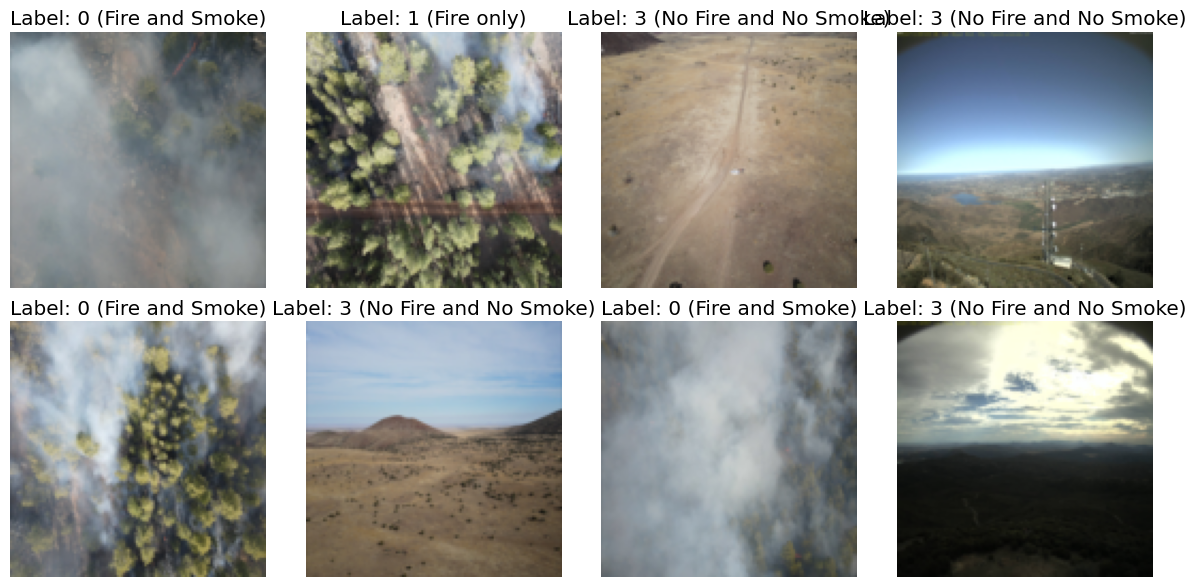

In [19]:
import os
import pandas as pd
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

IMG_SIZE=120
DATASET_PATH='C:\\Users\\User\\OneDrive - Technion\\Datasets'
BATCH_SIZE=64

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Load and prepare data from Excel
def load_image_label_data(images_dir, labels_excel_path):
    df = pd.read_csv(labels_excel_path)

    # Drop rows with missing fire or smoke labels
    df = df.dropna(subset=['fire', 'smoke'])

    # Ensure values are integers
    df['fire'] = df['fire'].astype(int)
    df['smoke'] = df['smoke'].astype(int)

    # Map labels to 0–3
    def map_label(row):
        if row['fire'] == 1 and row['smoke'] == 1:
            return 0
        elif row['fire'] == 1 and row['smoke'] == 0:
            return 1
        elif row['fire'] == 0 and row['smoke'] == 1:
            return 2
        else:
            return 3

    df['label'] = df.apply(map_label, axis=1)

    # Generate full image paths
    df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, x))

    # Filter out missing files
    df = df[df['image_path'].apply(os.path.exists)]

    image_paths = df['image_path'].tolist()
    labels = df['label'].tolist()
    return image_paths, labels

# Custom dataset from pre-split lists
class FireSmokeDatasetFromLists(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Visualization utility
def show_examples(dataset, num_images=8):
    label_names = {
        0: "Fire and Smoke",
        1: "Fire only",
        2: "Smoke only",
        3: "No Fire and No Smoke"
    }

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img, label = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label} ({label_names[label]})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Paths (replace with actual paths)
labels_excel_path = os.path.join(DATASET_PATH, 'labels.csv')
rgb_path = os.path.join(DATASET_PATH, 'rgb_images')
ir_path = os.path.join(DATASET_PATH, 'thermal_images')

# Load data
image_paths, labels = load_image_label_data(rgb_path, labels_excel_path)

# Stratified split: train (60%), validation (20%), test (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Create datasets
train_dataset = FireSmokeDatasetFromLists(train_paths, train_labels, transform=transform)
val_dataset = FireSmokeDatasetFromLists(val_paths, val_labels, transform=transform)
test_dataset = FireSmokeDatasetFromLists(test_paths, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Print sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Optional: show example images
show_examples(train_dataset)


## Classification-Guided Encoding
<a id=part2_2></a>

#### Training the model

cuda
*** Loading checkpoint file
Start training


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
g:\Projects\Flame2\functions\training.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.

0
50
0
50
0
50
--- EPOCH 1/50 ---
  Train Loss: 0.0887
  Val Loss: 0.1229
  Test Loss: 0.1263
0
50
0
50
0
50
--- EPOCH 2/50 ---
  Train Loss: 0.0833
  Val Loss: 0.1350
  Test Loss: 0.1337
0
50
0
50
0
50
--- EPOCH 3/50 ---
  Train Loss: 0.0613
  Val Loss: 0.1199
  Test Loss: 0.1338
*** Saved checkpoint at epoch 3
0
50
0
50
0
50
--- EPOCH 4/50 ---
  Train Loss: 0.0813
  Val Loss: 0.1207
  Test Loss: 0.1187
0
50
0
50
0
50
--- EPOCH 5/50 ---
  Train Loss: 0.0995
  Val Loss: 0.1074
  Test Loss: 0.1056
0
50
0
50
0
50
--- EPOCH 6/50 ---
  Train Loss: 0.0761
  Val Loss: 0.0843
  Test Loss: 0.0840
*** Saved checkpoint at epoch 6
0
50
0
50
0
50
--- EPOCH 7/50 ---
  Train Loss: 0.0749
  Val Loss: 0.0821
  Test Loss: 0.0895
*** Saved checkpoint at epoch 7
0
50
0
50
0
50
--- EPOCH 8/50 ---
  Train Loss: 0.0675
  Val Loss: 0.0700
  Test Loss: 0.0846
*** Saved checkpoint at epoch 8
0
50
0
50
0
50
--- EPOCH 9/50 ---
  Train Loss: 0.0624
  Val Loss: 0.0594
  Test Loss: 0.0699
*** Saved checkpoint at ep

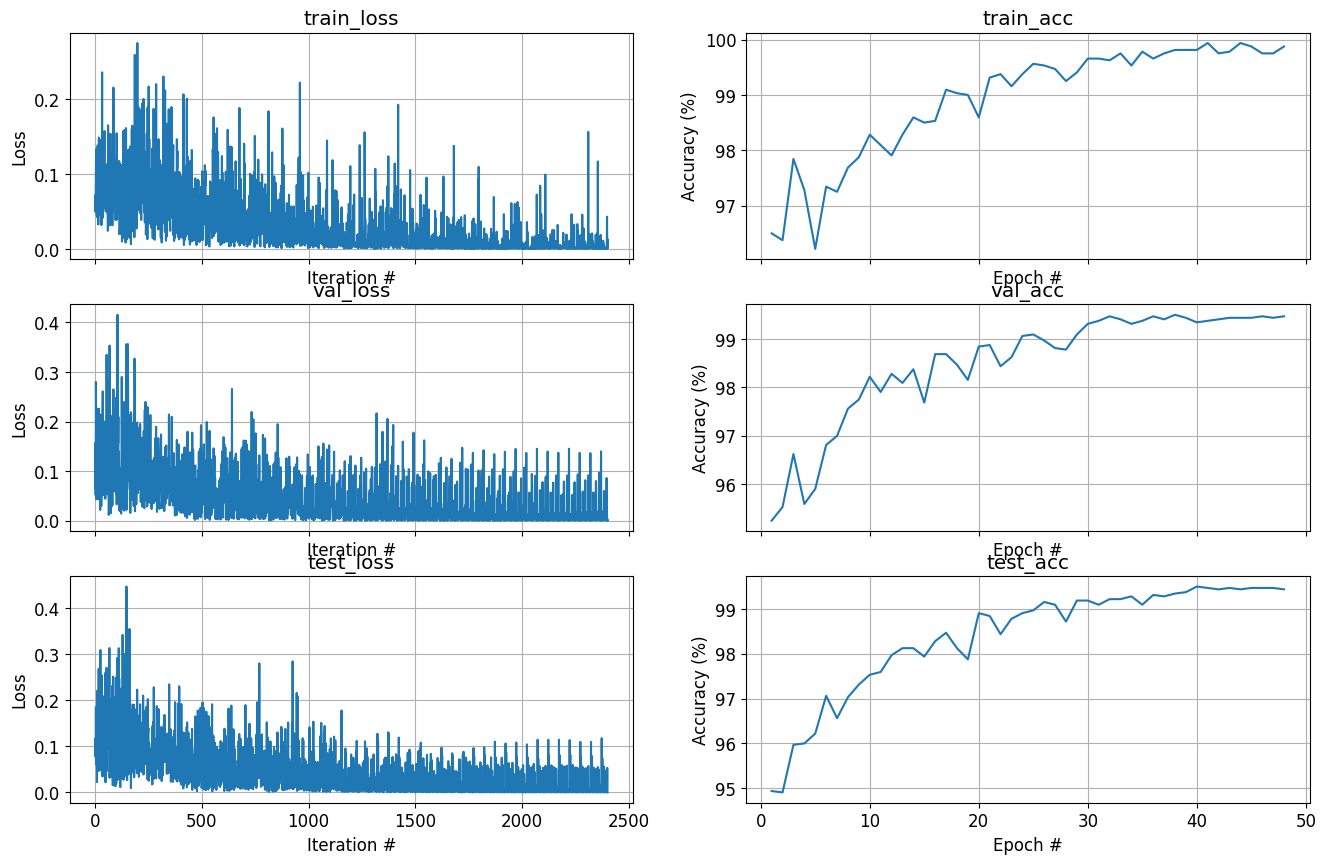

In [20]:
import sys
import os

sys.path.append(os.path.abspath('.'))

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from functions.training import ClassificationGuidedEncoding
from functions.plot import plot_fit

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize Model, Loss, and Optimizer
num_classes = 4

# Use pretrained ResNet18 and adjust the last layer
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001, weight_decay=1e-4)

# Initialize Trainer
trainer = ClassificationGuidedEncoding(resnet, loss_fn, optimizer, device)

# Training the Model
fig_optim = None
fit_res = trainer.fit(
    train_loader, val_loader, test_loader,
    num_epochs=50,
    checkpoints="resnet_fire_classifier",
    early_stopping=10,
    print_every=1,
    max_batches_per_epoch=50
)

fig, axes = plot_fit(fit_res, fig=fig_optim)

print("Training Complete! Model saved at resnet_fire_classifier.pt")


In [22]:
checkpoint = torch.load("resnet_fire_classifier.pt")
best_acc = checkpoint['best_acc']
print(f"Best Accuracy: {best_acc}%")

Best Accuracy: 99.5%


C:\Users\User\AppData\Local\Temp\ipykernel_15320\2452552818.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet_fire_classifier.pt")
